# Haystack Building Blocks

## Installing Haystack

Install Haystack and other required packages with `pip`:

In [ ]:
!pip install haystack-ai
!pip install trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.2/419.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2


In [ ]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

## Custom Component Requirements
#### Build a Custom Component


In [ ]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

In [ ]:
greeter = Greeter()

greeter.run(user_name="Tuana")

{'greeting': 'Hello Tuana'}

In [ ]:
from haystack.utils import Secret
from google.colab import userdata

In [ ]:
from haystack.components.builders import ChatPromptBuilder


In [ ]:
greeter = Greeter()
from haystack.dataclasses import ChatMessage


template = [
    ChatMessage.from_user(""" You will be given the beginning of a dialogue.
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script:
"""
    )
]


prompt = ChatPromptBuilder(template=template)

from haystack.components.generators.chat import AzureOpenAIChatGenerator

llm = AzureOpenAIChatGenerator(
    azure_endpoint=userdata.get('azure_endpoint'),
    api_key=Secret.from_token(userdata.get('api_key')),
    azure_deployment="gpt-35-turbo"
)


dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: ChatPromptBuilder
  - llm: AzureOpenAIChatGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.messages (List[ChatMessage])

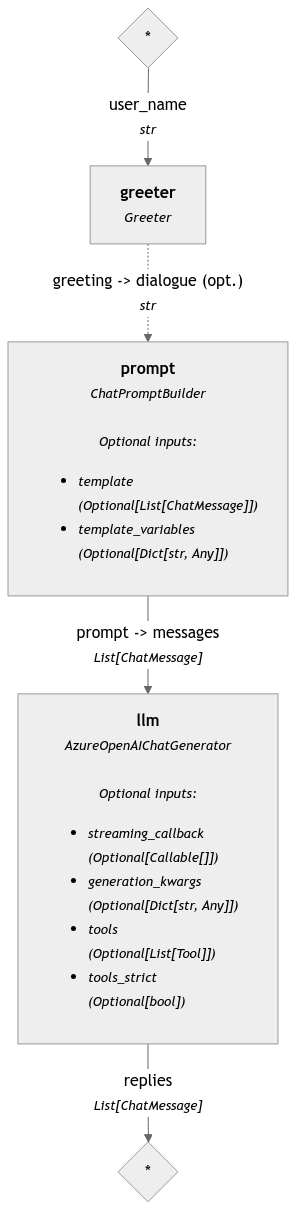

In [ ]:
dialogue_builder.show()

In [ ]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text="Scene: A coffee shop. Tuana is sitting at a table, sipping her coffee. Sarah enters and greets her.\n\nSarah: Hello Tuana. How are you?\n\nTuana: Hi, Sarah. I'm doing well, thanks. How about you?\n\nSarah: I'm hanging in there. I'm feeling a little stressed lately.\n\nTuana: Oh no, what's been going on?\n\nSarah: Work has been crazy busy and to top it off, my cat has been sick.\n\nTuana: I'm sorry to hear that. Is your cat okay now?\n\nSarah: Yeah, thankfully. The vet gave her some medicine and she's starting to feel better.\n\nTuana: That's a relief.\n\nSarah: So, what have you been up to lately?\n\nTuana: Not much, just trying to keep busy with work and my language classes. I'm learning Spanish.\n\nSarah: That's great. How's it going?\n\nTuana: It's been challenging but fun. I'm starting to get the hang of it.\n\nSarah: ¿Hablas español?\n\nTuana: Sí, un poco. ¿Y tú?\n\nSarah: No mucho. También estoy apre

In [ ]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'theden', 'descendants': 71, 'id': 42959775, 'kids': [42960461, 42961803, 42961449, 42961457, 42961830, 42961327, 42960428, 42961129, 42960683, 42961392, 42961099, 42960802, 42961764, 42961194, 42961311, 42962056, 42961756, 42961087, 42960622, 42961323, 42960639, 42961940, 42961244, 42961234, 42960538], 'score': 233, 'time': 1738824737, 'title': 'Linux Running in a PDF', 'type': 'story', 'url': 'https://linux.doompdf.dev/linux.pdf'}


In [ ]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [ ]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline

    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [ ]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

Can't download <Response [200]>, skipped
[Document(id=9ae43c787c00e1ad3b87dca35f05ae3017063e23e5a66472ca9e98015fa2f99d, content: 'Sergey Filimonov
Menu
About
Articles
Ingesting Millions of PDFs and why Gemini 2.0 Changes Everythin...', meta: {'content_type': 'text/html', 'url': 'https://www.sergey.fyi/articles/gemini-flash-2'}), Document(id=599e2b5d223e00af6ddd119a351562c1a68df9b9b8c2f1889df76e26ec6bd3c3, content: 'February 4, 2025
After 8 months of working on this post I don’t know how to start it except to say i...', meta: {'content_type': 'text/html', 'url': 'https://danielchasehooper.com/posts/code-animated-rick/'})]


In [ ]:
# prompt_template = [
#     ChatMessage.from_user("""
# You will be provided a few of the top posts in HackerNews.
# For each post, provide a brief summary if possible.

# Posts:
# {% for article in articles %}
#   Post:\n
#   {{ article.content}}
# {% endfor %}
# """)
# ]


prompt_template = [
    ChatMessage.from_user(
        """
You will be provided a few of the top posts in HackerNews.
For each post, provide a brief summary if possible.

Posts:
{% for article in articles %}
  Post:\n
  {{ article.content | truncate(4000) }}  # Truncate content to 4000 characters
{% endfor %}
"""
    )
]

In [ ]:
prompt_builder = ChatPromptBuilder(template=prompt_template)

fetcher = HackernewsNewestFetcher()

llm = AzureOpenAIChatGenerator(
    azure_endpoint=userdata.get('azure_endpoint'),
    api_key=Secret.from_token(userdata.get('api_key')),
    azure_deployment="gpt-35-turbo"
)
summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: ChatPromptBuilder
  - llm: AzureOpenAIChatGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.messages (List[ChatMessage])

In [ ]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 1}})

print(summaries["llm"]["replies"][0])

Can't download <Response [200]>, skipped
ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='1. "Ask HN: How do you start your day?" - This post is a discussion thread where people are sharing their morning routines and habits to kickstart their days effectively.\n2. "Show HN: A customizable dashboard with all your social media and website analytics" - The post showcases a web tool where users can integrate and visualize their website and social media analytics on a customizable dashboard.\n3. "Why we stopped using Basecamp 3: an open letter from a formerly happy customer" - In this post, the author shares their negative experience with Basecamp 3 and how it led them to switch to a different productivity tool.\n4. "Ask HN: How do you handle technical debt?" - This post is another discussion thread where people are sharing their approaches and strategies for managing and reducing technical debt in their software projects. \n5. "COVID-19 Mass Testing Can Work

In [ ]:
summaries

{'llm': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='1. "Ask HN: How do you start your day?" - This post is a discussion thread where people are sharing their morning routines and habits to kickstart their days effectively.\n2. "Show HN: A customizable dashboard with all your social media and website analytics" - The post showcases a web tool where users can integrate and visualize their website and social media analytics on a customizable dashboard.\n3. "Why we stopped using Basecamp 3: an open letter from a formerly happy customer" - In this post, the author shares their negative experience with Basecamp 3 and how it led them to switch to a different productivity tool.\n4. "Ask HN: How do you handle technical debt?" - This post is another discussion thread where people are sharing their approaches and strategies for managing and reducing technical debt in their software projects. \n5. "COVID-19 Mass Testing Can Work: Slovakia Did It" -